# Kaggle Titanic challenge

## Initial imports

In [96]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
from src import kaggle_api

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [145]:
# Load the train and test data.
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory analysis

What type of columns do we have, and what are their distributions?

In [102]:
print('Numerical columns:')
display(train.describe(include=np.number))
print('Categorical columns:')
display(train.describe(exclude=np.number))
print('Missing values:')
display(pd.concat([
    train_df.iloc[:, 1:].isna().sum().rename('train'),
    test_df.isna().sum().rename('test')
], axis=1))

Numerical columns:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Categorical columns:


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Marvin, Mr. Daniel Warner",male,347082,G6,S
freq,1,577,7,4,644


Missing values:


,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


The data inclues 10 columns of different types and complexity:
- Simple categorical values: `Sex`, `Embarked`, and `Pclass`.
- Discrete values: `SibSp` and `Parch`.
- Continuous values: `Age` (slightly skewed) and `Fare` (highly skewed).
- More complicated values: `Ticket`, `Cabin`, and `Name`.

_Note: `Age` and `Cabin` contain many missing values._

### Simple categorical values

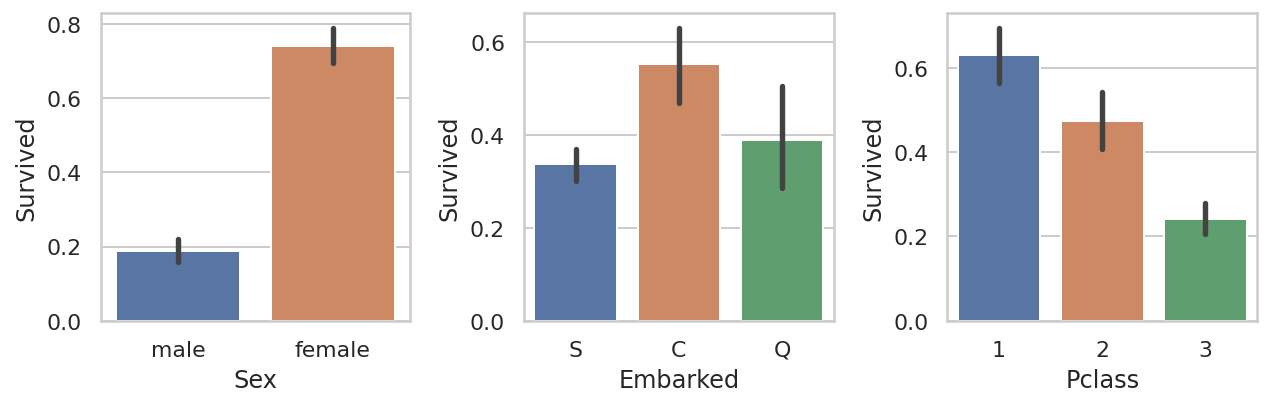

In [116]:
categorical_columns = ['Sex', 'Embarked', 'Pclass']

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, categorical_column in enumerate(categorical_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

### Discrete values

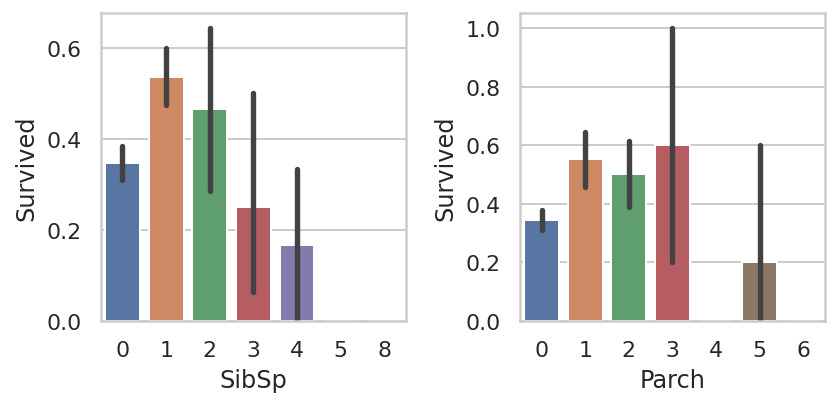

In [117]:
discrete_columns = ['SibSp', 'Parch']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

### Continuous values

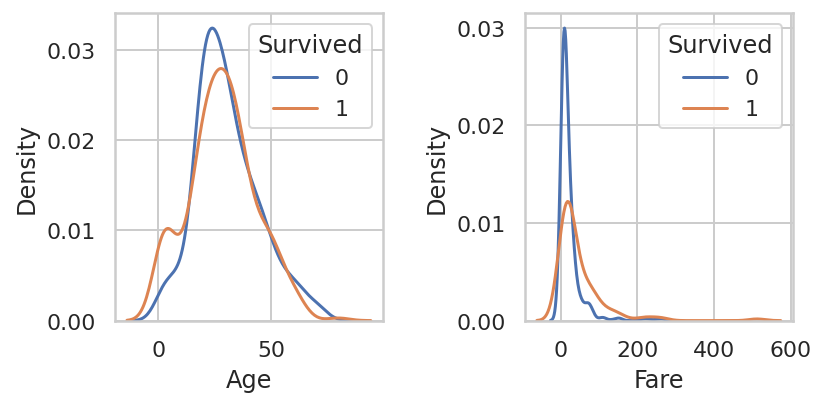

In [181]:
discrete_columns = ['Age', 'Fare']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.kdeplot(data=train[train['Survived'] == 0], x=categorical_column, ax=axes[i], label='0')
    sns.kdeplot(data=train[train['Survived'] == 1], x=categorical_column, ax=axes[i], label='1')
    axes[i].legend(title='Survived')
plt.tight_layout()

In [166]:
train = train.merge(pd.concat([train, test]).assign(Ticket_count=1).groupby('Ticket')['Ticket_count'].count(), on='Ticket')

<AxesSubplot:xlabel='asdf', ylabel='Count'>

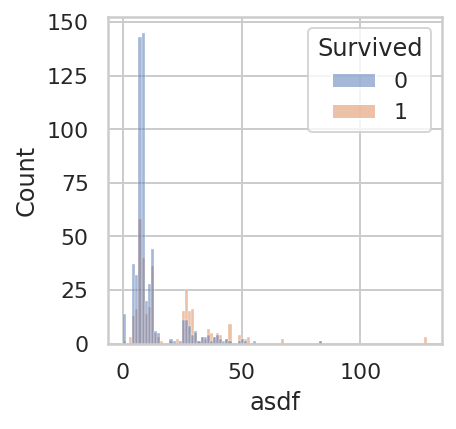

In [167]:
train['asdf'] = train['Fare'] / train['Ticket_count']
sns.histplot(data=train, x='asdf', hue='Survived')

## Clean data

,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


In [6]:
test_submission = (test['Sex'] != 'male').rename('Survived').astype(int)
kaggle_api.submit('titanic', test_submission, 'Test submission from API that should fail')

100%|██████████| 2.77k/2.77k [00:00<00:00, 4.33kB/s]


'0.76555'